In [4]:
import numpy as np
import tensorflow as tf
tf.get_logger().setLevel('INFO')

from tensorflow import set_random_seed
set_random_seed(0)

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, SimpleRNN, TimeDistributed

# TF RNN

In [5]:
# data
x = np.array([[[2]]])

# input/output shape
inputs = Input((1,1)) # just one timestep
outputs = 1

# MODEL
output, state = SimpleRNN(outputs, return_state=True, activation='relu')(inputs)
model = Model(inputs=inputs, outputs=[output, state])

# print output and state
output, state = model.predict(x)
print('output: ', output)
print('state: ', state)
print('~~~~~~~~~~~~~~')
print('weights: ', model.get_weights())

output:  [[0.]]
state:  [[0.]]
~~~~~~~~~~~~~~
weights:  [array([[-1.2793897]], dtype=float32), array([[-1.]], dtype=float32), array([0.], dtype=float32)]


In [6]:
print(model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1, 1)]            0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     [(None, 1), (None, 1)]    3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________
None


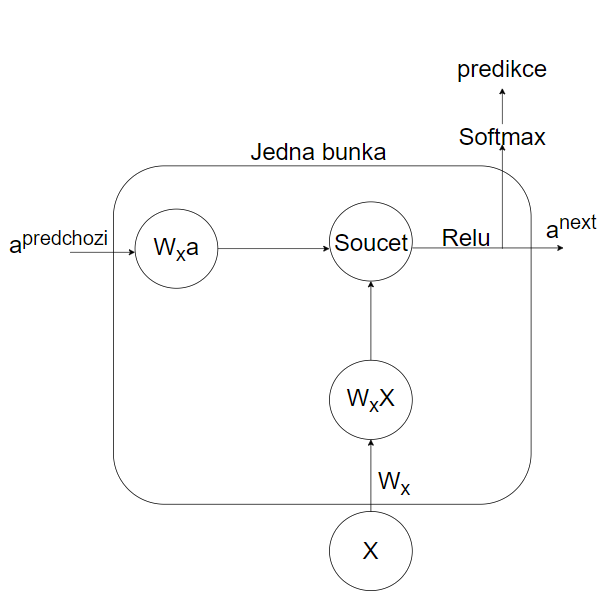

In [8]:
from IPython.display import Image
Image("rnn_cell.png")

# Numpy RNN 

In [9]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

# Bias is omited to keep it easy
def rnn_cell_ffw(xt, a_prev, params):

    # input weight
    Wax = params["Wax"]
    # input from previous layer weight
    Waa = params["Waa"]
    # output weight
    Wya = params["Wya"]
    
    # input to the next cell
    a_next = np.maximum(np.dot(Waa, a_prev) + np.dot(Wax, xt), 0) #relu
    
    # final output from the cell
    yt_pred = softmax(np.dot(Wya, a_next))
    
    # store the params
    cache = (a_next, a_prev, xt, params)
    
    return a_next, yt_pred, cache